In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import re

In [2]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)
movie_df = pd.read_csv(movielens_dir / "movies.csv")

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [5]:
genres_dict = dict()
for movie in movie_ids:
    for genre in movie_df[movie_df.movieId == movie].iloc[0]['genres'].split('|'):
        if genre in genres_dict.keys():
            genres_dict[genre] = genres_dict[genre] + 1
        else: genres_dict[genre] = 1

In [6]:
genres_dict = {k: v for k, v in sorted(genres_dict.items(), key=lambda item: item[1],reverse=True)}
genres_dict

{'Drama': 4349,
 'Comedy': 3753,
 'Thriller': 1889,
 'Action': 1828,
 'Romance': 1591,
 'Adventure': 1262,
 'Crime': 1196,
 'Sci-Fi': 980,
 'Horror': 977,
 'Fantasy': 778,
 'Children': 664,
 'Animation': 610,
 'Mystery': 573,
 'Documentary': 438,
 'War': 381,
 'Musical': 333,
 'Western': 167,
 'IMAX': 158,
 'Film-Noir': 85,
 '(no genres listed)': 34}

In [7]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [8]:
embedding_dim = 32
hidden_units = [64, 32]

user_input = tf.keras.Input(shape=(1,), dtype=tf.int32, name='user_input')
movie_input = tf.keras.Input(shape=(1,), dtype=tf.int32, name='movie_input')

user_embedding = tf.keras.layers.Embedding(input_dim=num_users, output_dim=embedding_dim,name='user_embedding')(user_input)
movie_embedding = tf.keras.layers.Embedding(input_dim=num_movies, output_dim=embedding_dim)(movie_input)

user_embedding = tf.keras.layers.Flatten()(user_embedding)
movie_embedding = tf.keras.layers.Flatten()(movie_embedding)

concatenated = tf.keras.layers.Concatenate()([user_embedding, movie_embedding])

for units in hidden_units:
    concatenated = tf.keras.layers.Dense(units, activation='relu')(concatenated)

output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated)

model = tf.keras.Model(inputs=[user_input, movie_input], outputs=output)

model.compile(optimizer="Adam",loss="mse")

In [9]:
history = model.fit(
    [x_train[:, 0], x_train[:, 1]],
    y_train,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
    batch_size=64,
    epochs=5
)

Epoch 1/5
1418/1418 [==============================] - 6s 3ms/step - loss: 0.0404 - val_loss: 0.0380
Epoch 2/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.0337 - val_loss: 0.0370
Epoch 3/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.0307 - val_loss: 0.0377
Epoch 4/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.0280 - val_loss: 0.0386
Epoch 5/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.0250 - val_loss: 0.0397


In [10]:
user_embeddings = model.get_layer('user_embedding').get_weights()[0]

similarity_matrix = 1 - cosine_distances(user_embeddings)

In [11]:
display(pd.DataFrame(similarity_matrix))

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,1.000000,-0.137217,-0.775259,-0.292182,-0.083989,-0.107405,-0.145972,0.155846,0.048333,-0.347257,...,0.729857,-0.102922,0.037865,-0.121130,-0.377717,0.272994,0.360741,-0.330393,-0.215931,0.385586
1,-0.137217,1.000000,-0.010721,-0.435553,-0.403120,0.512622,-0.446482,-0.508268,0.075587,0.019742,...,0.166290,0.400138,-0.230140,0.083950,0.021974,0.000894,0.308570,0.347284,-0.326080,-0.406767
2,-0.775259,-0.010721,1.000000,0.272323,0.017342,0.021135,0.333206,-0.078443,0.051440,0.283916,...,-0.751075,0.042235,-0.034917,-0.106674,0.117366,-0.276095,-0.425932,0.321025,0.205558,-0.209793
3,-0.292182,-0.435553,0.272323,1.000000,0.273368,-0.487902,0.286788,0.283106,0.139531,0.015438,...,-0.299980,-0.164717,-0.080800,-0.074291,-0.045549,-0.254136,-0.524930,-0.254563,-0.026375,-0.282790
4,-0.083989,-0.403120,0.017342,0.273368,1.000000,-0.346488,-0.004072,0.680761,-0.206541,-0.120916,...,-0.284433,-0.290629,0.561943,0.360579,-0.075940,0.229413,-0.202547,-0.459911,0.026758,0.225893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.272994,0.000894,-0.276095,-0.254136,0.229413,0.324799,-0.050192,-0.027659,-0.331013,-0.318552,...,-0.084279,-0.269448,0.336308,0.083539,-0.053857,1.000000,-0.190744,-0.418659,0.146569,0.104021
606,0.360741,0.308570,-0.425932,-0.524930,-0.202547,0.257098,-0.458789,-0.031237,-0.211604,0.269928,...,0.521364,0.023634,-0.148034,0.323401,0.219568,-0.190744,1.000000,0.038382,-0.088733,0.064529
607,-0.330393,0.347284,0.321025,-0.254563,-0.459911,0.207132,0.088885,-0.485016,0.237296,-0.002870,...,0.088973,0.280702,-0.290911,-0.338581,0.015247,-0.418659,0.038382,1.000000,-0.097028,-0.035548
608,-0.215931,-0.326080,0.205558,-0.026375,0.026758,0.248101,0.085508,0.228356,-0.294448,0.381209,...,-0.429881,0.060129,-0.022793,0.259331,0.355688,0.146569,-0.088733,-0.097028,1.000000,0.103616


In [38]:
target_user_id = 1
n_clusters = 5

In [39]:
k_means = KMeans(n_clusters = n_clusters,n_init = 'auto').fit(user_embeddings)

In [14]:
def TF_IDF(movieId):
    tf = len(df[(df.movieId == movieId)]) / len(df)
    k = 0
    rating = 0
    for user_id in user_ids:
        curr_favourite_movies = df[df.userId == user_id].sort_values(by="rating", ascending=False).head(30).movieId.values
        if movieId in curr_favourite_movies:
            k+=1
            rating += df[(df.userId == user_id) & (df.movieId == movieId)].iloc[0]['rating'].astype(float)
    if k != 0:
        idf = math.log(num_users / k)
        return tf*idf*rating
    else: return 0

In [73]:
def get_recommended_movies_for_cluster(label,target_cluster):
    movies_dict = dict()
    num_users_cluster = len(np.where(label == target_cluster)[0])
    for user in user2user_encoded.values():
        if label[user] == target_cluster:
            recommended_movies = get_recommended_movies(userencoded2user[user],30)
            for movie in recommended_movies:
                if(movie in movies_dict.keys()):
                    movies_dict[movie] = movies_dict[movie] + df[df.movieId == movie]['rating'].iloc[0].astype(float)
                else:
                    movies_dict[movie] = df[df.movieId==movie]['rating'].iloc[0].astype(float)
    movies_dict = {k: v for k, v in sorted(movies_dict.items(), key=lambda item: item[1],reverse=True)}
    for key in movies_dict.keys():
        movies_dict[key] = (movies_dict[key]/num_users_cluster) * TF_IDF(key)
    return movies_dict

In [16]:
def get_favourite_movies(target_user_id, n):
    movies_watched_by_user = df[df.userId == target_user_id]
    top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(n)
    .movieId.values
    )
    return top_movies_user

def get_recommended_movies(target_user_id,n):
    movies_watched_by_user = df[df.userId == target_user_id]
    movies_not_watched = movie_df[
        ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(target_user_id)
    user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    ratings = model.predict([user_movie_array[:, 0],user_movie_array[:, 1]]).flatten()
    top_ratings_indices = ratings.argsort()[-n:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]
    return recommended_movie_ids

In [17]:
target_cluster = k_means.labels_[target_user_id - 1]

In [18]:
movies_dict = get_recommended_movies_for_cluster(k_means.labels_,target_cluster)

301/301 [==============================] - 0s 547us/step


In [19]:
movies_dict

{3451: 5.0,
 170705: 4.940476190476191,
 177593: 4.523809523809524,
 6666: 4.392857142857143,
 1066: 3.2857142857142856,
 7008: 3.2142857142857144,
 5889: 3.0952380952380953,
 171749: 2.9761904761904763,
 92259: 2.857142857142857,
 172577: 2.857142857142857,
 2360: 2.7142857142857144,
 2563: 2.625,
 127098: 2.5595238095238093,
 162578: 2.380952380952381,
 104879: 2.3214285714285716,
 71268: 2.261904761904762,
 95311: 2.261904761904762,
 7981: 2.25,
 42632: 2.0892857142857144,
 2202: 2.0476190476190474,
 2131: 2.0476190476190474,
 6460: 1.9821428571428572,
 1223: 1.7678571428571428,
 147328: 1.7261904761904763,
 6442: 1.6666666666666667,
 1148: 1.6666666666666667,
 78836: 1.6666666666666667,
 158027: 1.6666666666666667,
 3302: 1.6607142857142858,
 90430: 1.5833333333333333,
 26810: 1.5535714285714286,
 173355: 1.5476190476190477,
 104780: 1.4880952380952381,
 4077: 1.4761904761904763,
 66371: 1.4464285714285714,
 93320: 1.369047619047619,
 40412: 1.3392857142857142,
 318: 1.309523809523

In [22]:
favourite_movies = get_favourite_movies(target_user_id,10)
favourite_movies_df = movie_df[movie_df.movieId.isin(favourite_movies)]
for row in favourite_movies_df.itertuples():
    print(row.title, ":", row.genres)

Tommy Boy (1995) : Comedy
Tombstone (1993) : Action|Drama|Western
Three Caballeros, The (1945) : Animation|Children|Musical
Reservoir Dogs (1992) : Crime|Mystery|Thriller
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Star Wars: Episode VI - Return of the Jedi (1983) : Action|Adventure|Sci-Fi
Full Metal Jacket (1987) : Drama|War
Henry V (1989) : Action|Drama|Romance|War
Newton Boys, The (1998) : Crime|Drama
Mad Max (1979) : Action|Adventure|Sci-Fi


In [23]:
movies_watched_by_user = df[df.userId == target_user_id]
recommended_movies = movie_df[(movie_df["movieId"].isin(movie_dict_with_TF_IDF.keys())) & 
                              (~movie_df["movieId"].isin(movies_watched_by_user['movieId']))]
recommended_movies_without_tf_idf = movie_df[(movie_df["movieId"].isin(movies_dict.keys())) & 
                              (~movie_df["movieId"].isin(movies_watched_by_user['movieId']))]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)
print(len(recommended_movies))

Mr. Holland's Opus (1995) : Drama
Heidi Fleiss: Hollywood Madam (1995) : Documentary
Shawshank Redemption, The (1994) : Crime|Drama
Live Nude Girls (1995) : Comedy
World of Apu, The (Apur Sansar) (1959) : Drama
Wallace & Gromit: The Best of Aardman Animation (1996) : Adventure|Animation|Comedy
Emma (1996) : Comedy|Drama|Romance
Godfather, The (1972) : Crime|Drama
Philadelphia Story, The (1940) : Comedy|Drama|Romance
Rear Window (1954) : Mystery|Thriller
Casablanca (1942) : Drama|Romance
To Catch a Thief (1955) : Crime|Mystery|Romance|Thriller
His Girl Friday (1940) : Comedy|Romance
Freeway (1996) : Comedy|Crime|Drama|Thriller
Die Hard (1988) : Action|Crime|Thriller
Secrets & Lies (1996) : Drama
Shall We Dance (1937) : Comedy|Musical|Romance
Wallace & Gromit: The Wrong Trousers (1993) : Animation|Children|Comedy|Crime
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
12 Angry Men (1957) : Drama
Third Man, The (1949) : Film-Noir|Mystery|

In [24]:
genres_4 = dict()
genres_5 = dict()
movies_watched_by_user = df[df.userId == target_user_id]
for movie in movies_watched_by_user.itertuples():
    if(df[(df.userId == target_user_id) & (df.movieId == movie.movieId)].iloc[0]['rating'].astype(int) == 5):
        for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_5.keys()):
                genres_5[genre] = genres_5[genre] + 1
            else: genres_5[genre] = 1
    if(df[(df.userId == target_user_id) & (df.movieId == movie.movieId)].iloc[0]['rating'].astype(int) == 4):
        for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_4.keys()):
                genres_4[genre] = genres_4[genre] + 1
            else: genres_4[genre] = 1

In [25]:
genres_recommended = dict()
for movie in recommended_movies.itertuples():
    for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_recommended.keys()):
                genres_recommended[genre] = genres_recommended[genre] + 1
            else: genres_recommended[genre] = 1

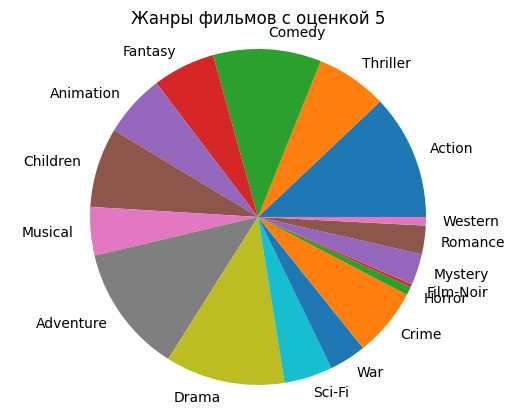

In [27]:
labels = []
sizes = []
for x, y in genres_5.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры фильмов с оценкой 5')
plt.pie(sizes, labels=labels)
plt.axis('equal')

plt.show()

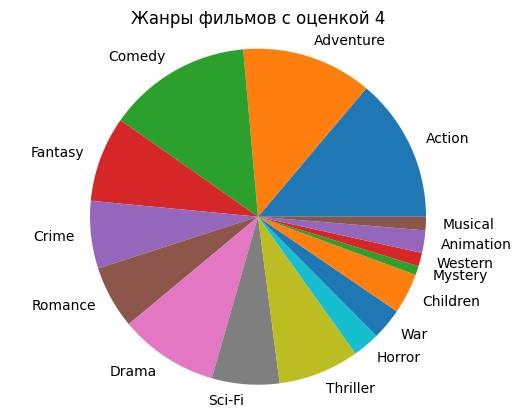

In [28]:
labels = []
sizes = []
for x, y in genres_4.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры фильмов с оценкой 4')
plt.pie(sizes, labels=labels)
plt.axis('equal')
plt.show()

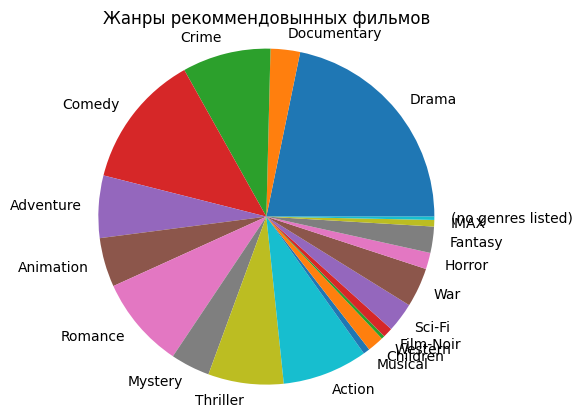

In [29]:
labels = []
sizes = []
for x, y in genres_recommended.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры рекоммендовынных фильмов')
plt.pie(sizes, labels=labels)
plt.axis('equal')

plt.show()

In [31]:
def top_n_similar_users(user_id,n):
    return np.argsort(np.delete(similarity_matrix[user_id - 1],user_id - 1))[-n:] + 1

In [32]:
def nth_similar_user(user_id,n):
     return np.argsort(np.delete(similarity_matrix[user_id - 1],user_id - 1))[-(n + 1)] + 1

In [34]:
rmse = 0
n = 10
similar_users = top_n_similar_users(target_user_id,n)
movies_watched_by_user = df[df.userId == target_user_id]
df_user = movies_watched_by_user[['movieId', 'rating']]

for similar_user_id in similar_users:
    movies_watched_by_similar_user = df[df.userId == similar_user_id]
    df_similar_user = movies_watched_by_similar_user[['movieId', 'rating']]  
    corresponding_movie_ids = df_similar_user[df_similar_user.movieId.isin(df_user.movieId)]['movieId']            
    for movie_id in corresponding_movie_ids:
        rmse += math.pow(df_user[df_user.movieId == movie_id].iloc[0]['rating'] - 
                         df_similar_user[df_similar_user.movieId == movie_id].iloc[0]['rating'],2)
    rmse = math.sqrt(rmse*1/n)
    print(str(rmse) + str(corresponding_movie_ids.shape))

1.449137674618944(13,)
1.0700064333740682(12,)
1.3809419406106134(14,)
2.7546495592109466(61,)
1.3324657428696225(13,)
2.541308043958261(44,)
0.950857930710906(8,)
3.3459058254934626(33,)
1.5522855995432496(20,)
0.7779643693346919(3,)


In [35]:
tmp_user = []
tmp_similar_user = []
similar_user_id = similar_users[1]

str_target = 'user ' + str(target_user_id)
str_similar = 'user ' + str(similar_user_id)

movies_watched_by_similar_user = df[df.userId == similar_user_id]
df_similar_user = movies_watched_by_similar_user[['movieId', 'rating']]  
corresponding_movie_ids = df_similar_user[df_similar_user.movieId.isin(df_user.movieId)]['movieId']

comparison_df = pd.DataFrame(index=corresponding_movie_ids,columns=[str_target,str_similar])

for i in corresponding_movie_ids:
    tmp_user.append(float(df[(df['movieId'] ==  i) & (df['userId'] == target_user_id)]['rating'].iloc[0]))
    tmp_similar_user.append(float(df[(df['movieId'] ==  i) & (df['userId'] == similar_user_id)]['rating'].iloc[0]))
    
comparison_df[str_target] = tmp_user
comparison_df[str_similar] = tmp_similar_user
comparison_df

,user 1,user 170
movieId,,
553,5.0,4.0
110,4.0,4.0
500,3.0,4.0
733,4.0,3.0
736,3.0,3.0
480,4.0,3.0
356,4.0,4.0
296,3.0,2.0
593,4.0,4.0


In [74]:
movies_for_clusters = dict()
def get_recommended_movies_for_all_clusters(label):
    for i in range(n_clusters):
        movies_for_clusters[i] = get_recommended_movies_for_cluster(label,i)

In [ ]:
get_recommended_movies_for_all_clusters(k_means.labels_)

299/299 [==============================] - 0s 540us/step


299/299 [==============================] - 0s 560us/step


303/303 [==============================] - 0s 550us/step


  1/303 [..............................] - ETA: 4s

In [ ]:
movies_for_clusters

In [69]:
genres_recommended_for_all_clusters = dict()
genres_recommended_tmp = dict()
for cluster in movies_for_clusters.keys():
    num_users_cluster = len(np.where(k_means.labels_ == cluster)[0])
    for movie in movies_for_clusters[cluster].keys():
        for genre in movie_df[movie_df.movieId == movie].iloc[0]['genres'].split('|'):
            if(genre in genres_recommended_tmp.keys()):
                genres_recommended_tmp[genre] = genres_recommended_tmp[genre] + 1
            else: genres_recommended_tmp[genre] = 1
    genres_recommended_tmp = {k: v for k, v in sorted(genres_recommended_tmp.items(), key=lambda item: item[1],reverse=True)}
    for key in genres_recommended_tmp.keys():
        genres_recommended_tmp[key] = (genres_recommended_tmp[key]/num_users_cluster)
    genres_recommended_for_all_clusters[cluster] = genres_recommended_tmp
    genres_recommended_tmp = dict()

In [70]:
genres_recommended_for_all_clusters

{0: {'Drama': 1.4258064516129032,
  'Comedy': 1.1741935483870967,
  'Action': 0.4774193548387097,
  'Crime': 0.47096774193548385,
  'Romance': 0.47096774193548385,
  'Thriller': 0.4645161290322581,
  'Adventure': 0.36129032258064514,
  'Animation': 0.3032258064516129,
  'Documentary': 0.23225806451612904,
  'Fantasy': 0.21935483870967742,
  'Children': 0.2129032258064516,
  'Sci-Fi': 0.1935483870967742,
  'War': 0.17419354838709677,
  'Horror': 0.16774193548387098,
  'Mystery': 0.14193548387096774,
  'Musical': 0.09032258064516129,
  'IMAX': 0.04516129032258064,
  'Film-Noir': 0.03870967741935484,
  'Western': 0.025806451612903226,
  '(no genres listed)': 0.01935483870967742},
 1: {'Drama': 0.952054794520548,
  'Comedy': 0.6712328767123288,
  'Crime': 0.3767123287671233,
  'Romance': 0.2808219178082192,
  'Animation': 0.273972602739726,
  'Thriller': 0.2534246575342466,
  'Action': 0.23972602739726026,
  'Adventure': 0.2191780821917808,
  'War': 0.1643835616438356,
  'Documentary': 0.1

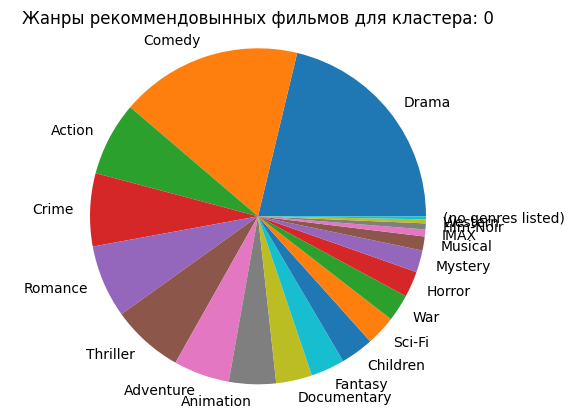

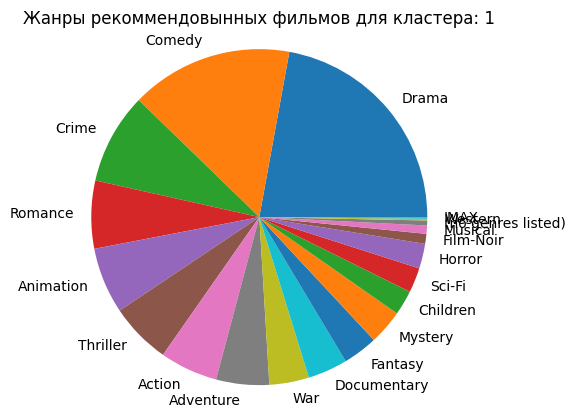

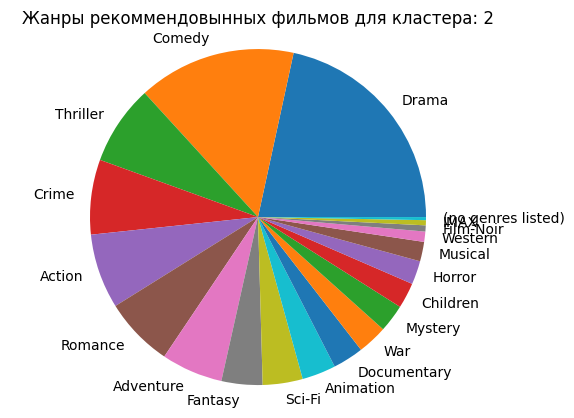

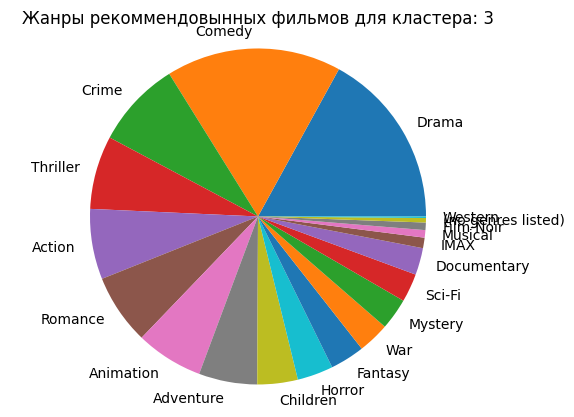

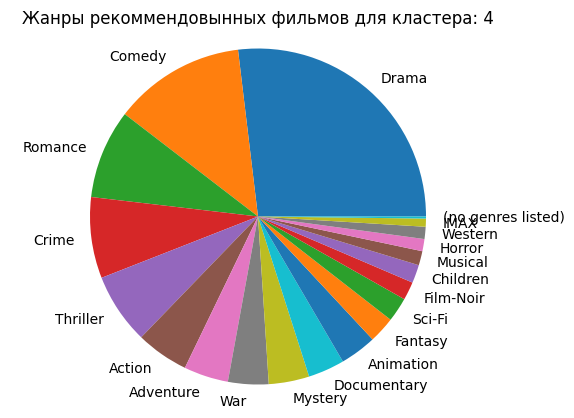

In [72]:
for i in genres_recommended_for_all_clusters.keys():
    labels = []
    sizes = []
    for x, y in genres_recommended_for_all_clusters[i].items():
        labels.append(x)
        sizes.append(y)
    plt.title('Жанры рекоммендовынных фильмов для кластера: ' + str(i))
    plt.pie(sizes, labels=labels)
    plt.axis('equal')

    plt.show()